Shapefile Fields: [('DeletionFlag', 'C', 1, 0), ['featurecla', 'C', 15, 0], ['scalerank', 'N', 1, 0], ['LABELRANK', 'N', 2, 0], ['SOVEREIGNT', 'C', 32, 0], ['SOV_A3', 'C', 3, 0], ['ADM0_DIF', 'N', 1, 0], ['LEVEL', 'N', 1, 0], ['TYPE', 'C', 17, 0], ['TLC', 'C', 1, 0], ['ADMIN', 'C', 36, 0], ['ADM0_A3', 'C', 3, 0], ['GEOU_DIF', 'N', 1, 0], ['GEOUNIT', 'C', 36, 0], ['GU_A3', 'C', 3, 0], ['SU_DIF', 'N', 1, 0], ['SUBUNIT', 'C', 36, 0], ['SU_A3', 'C', 3, 0], ['BRK_DIFF', 'N', 1, 0], ['NAME', 'C', 29, 0], ['NAME_LONG', 'C', 36, 0], ['BRK_A3', 'C', 3, 0], ['BRK_NAME', 'C', 32, 0], ['BRK_GROUP', 'C', 17, 0], ['ABBREV', 'C', 16, 0], ['POSTAL', 'C', 4, 0], ['FORMAL_EN', 'C', 52, 0], ['FORMAL_FR', 'C', 35, 0], ['NAME_CIAWF', 'C', 45, 0], ['NOTE_ADM0', 'C', 16, 0], ['NOTE_BRK', 'C', 63, 0], ['NAME_SORT', 'C', 36, 0], ['NAME_ALT', 'C', 19, 0], ['MAPCOLOR7', 'N', 1, 0], ['MAPCOLOR8', 'N', 1, 0], ['MAPCOLOR9', 'N', 1, 0], ['MAPCOLOR13', 'N', 3, 0], ['POP_EST', 'N', 12, 1], ['POP_RANK', 'N', 2, 0], ['P

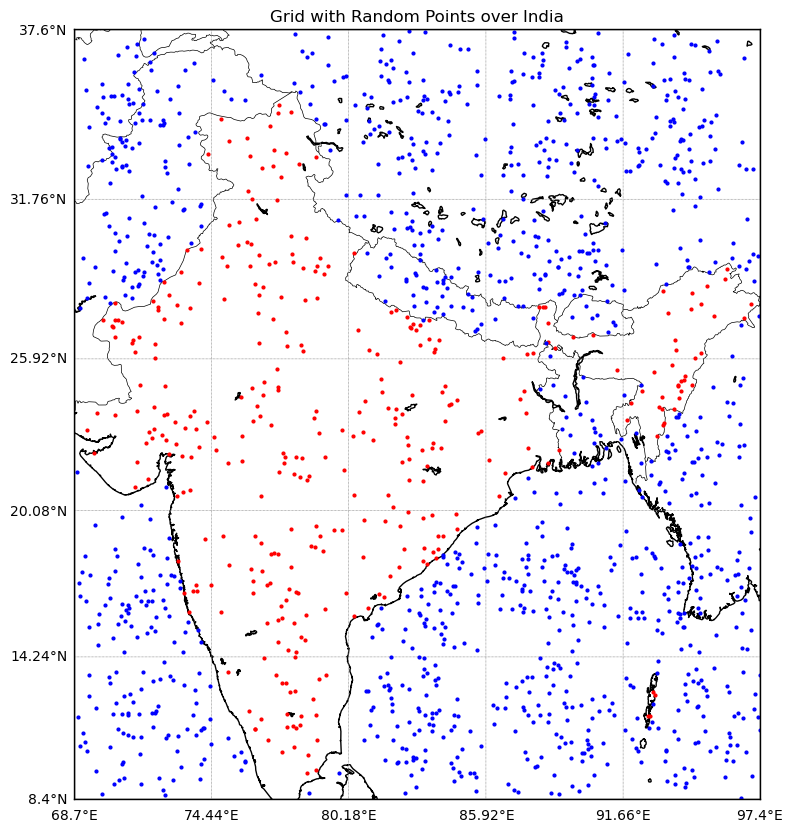

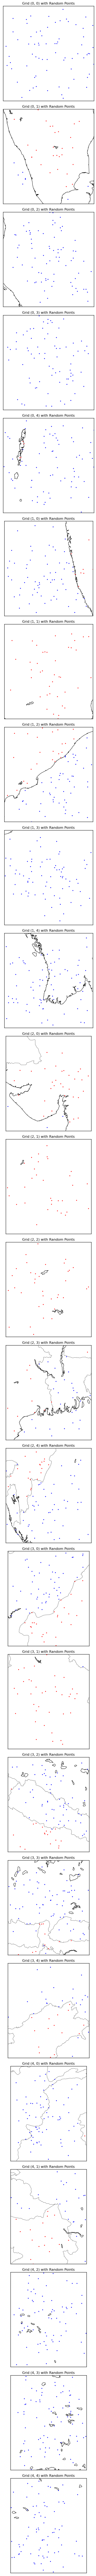

In [5]:
import shapefile
from shapely.geometry import Point, shape
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import random

# Define the boundaries of India
min_lat, max_lat = 8.4, 37.6
min_lon, max_lon = 68.7, 97.4

# Load the shapefile for India's boundaries
sf = shapefile.Reader("/Users/parasdhiman/Desktop/DRDO/ne_10m_admin_0_countries 2/ne_10m_admin_0_countries.shp")

# Print fields to find the correct field for country names
print("Shapefile Fields:", sf.fields)

# Identify the field containing country names
country_name_field = None
for field in sf.fields:
    if 'name' in field[0].lower():
        country_name_field = field[0]
        break

if country_name_field is None:
    raise ValueError("Field containing country names not found in the shapefile.")

# Extract the shape of India
india_shape = None
for shape_rec in sf.shapeRecords():
    if 'India' in shape_rec.record[country_name_field]:
        india_shape = shape_rec.shape
        break

if india_shape is None:
    raise ValueError("India's shape not found in the shapefile.")

def point_in_india(lat, lon):
    """Check if a given point is inside India using the shapefile."""
    point = Point(lon, lat)
    india_polygon = shape(india_shape.__geo_interface__)
    return india_polygon.contains(point)

# Continue with the rest of your code for plotting and generating points


# Define the size of each grid cell
grid_size_lat = (max_lat - min_lat) / 5
grid_size_lon = (max_lon - min_lon) / 5

# Create a map centered around India
fig, ax = plt.subplots(figsize=(10, 10))
m = Basemap(projection='merc', llcrnrlat=min_lat, urcrnrlat=max_lat,
            llcrnrlon=min_lon, urcrnrlon=max_lon, resolution='i', ax=ax)

# Draw map boundaries and coastlines
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()

# Calculate the number of grids
lat_grids = int((max_lat - min_lat) / grid_size_lat)
lon_grids = int((max_lon - min_lon) / grid_size_lon)

# Draw the grid
parallels = [min_lat + i * grid_size_lat for i in range(lat_grids + 1)]
meridians = [min_lon + j * grid_size_lon for j in range(lon_grids + 1)]

m.drawparallels(parallels, labels=[1,0,0,0], color='grey', dashes=[1, 1], linewidth=0.5)
m.drawmeridians(meridians, labels=[0,0,0,1], color='grey', dashes=[1, 1], linewidth=0.5)

# Generate random points within each grid
random_points_inside = []
random_points_outside = []

# Store grid cells that intersect with India
intersecting_grids = []

for i in range(lat_grids):
    for j in range(lon_grids):
        grid_min_lat = min_lat + i * grid_size_lat
        grid_max_lat = grid_min_lat + grid_size_lat
        grid_min_lon = min_lon + j * grid_size_lon
        grid_max_lon = grid_min_lon + grid_size_lon

        # Generate points using Gaussian distribution with increased variance
        lat_mean = (grid_max_lat + grid_min_lat) / 2
        lon_mean = (grid_max_lon + grid_min_lon) / 2
        lat_std = (grid_max_lat - grid_min_lat) / 3  # Increased variance
        lon_std = (grid_max_lon - grid_min_lon) / 3  # Increased variance

        # Check if the grid cell is entirely within India
        points_to_generate = 50 if point_in_india(lat_mean, lon_mean) else 100
        grid_points_inside = []
        grid_points_outside = []

        for _ in range(points_to_generate):
            rand_lat = random.gauss(lat_mean, lat_std)
            rand_lon = random.gauss(lon_mean, lon_std)

            # Ensure the points are within the grid boundaries
            if grid_min_lat <= rand_lat <= grid_max_lat and grid_min_lon <= rand_lon <= grid_max_lon:
                if point_in_india(rand_lat, rand_lon):
                    random_points_inside.append((rand_lat, rand_lon))
                    grid_points_inside.append((rand_lat, rand_lon))
                else:
                    random_points_outside.append((rand_lat, rand_lon))
                    grid_points_outside.append((rand_lat, rand_lon))

        if grid_points_inside or grid_points_outside:
            intersecting_grids.append((i, j, grid_points_inside, grid_points_outside))

# Plot random points inside India on the map (in red)
for point in random_points_inside:
    x, y = m(point[1], point[0])
    m.plot(x, y, 'ro', markersize=2)  # Red color

# Plot random points outside India on the map (in blue)
for point in random_points_outside:
    x, y = m(point[1], point[0])
    m.plot(x, y, 'bo', markersize=2)  # Blue color

plt.title('Grid with Random Points over India')
plt.show()

# Plot distribution for each grid that covers India
fig, axes = plt.subplots(len(intersecting_grids), 1, figsize=(10, len(intersecting_grids) * 5))

for idx, (i, j, grid_points_inside, grid_points_outside) in enumerate(intersecting_grids):
    ax = axes[idx] if len(intersecting_grids) > 1 else axes
    grid_min_lat = min_lat + i * grid_size_lat
    grid_max_lat = grid_min_lat + grid_size_lat
    grid_min_lon = min_lon + j * grid_size_lon
    grid_max_lon = grid_min_lon + grid_size_lon

    m = Basemap(projection='merc', llcrnrlat=grid_min_lat, urcrnrlat=grid_max_lat,
                llcrnrlon=grid_min_lon, urcrnrlon=grid_max_lon, resolution='i', ax=ax)

    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary()

    for point in grid_points_inside:
        x, y = m(point[1], point[0])
        m.plot(x, y, 'ro', markersize=2)  # Red color

    for point in grid_points_outside:
        x, y = m(point[1], point[0])
        m.plot(x, y, 'bo', markersize=2)  # Blue color

    ax.set_title(f'Grid ({i}, {j}) with Random Points')

plt.tight_layout()
plt.show()


In [7]:
import csv
# Save random points to CSV
def save_points_to_csv(points, filename):
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Latitude', 'Longitude'])
        for point in points:
            csv_writer.writerow(point)
# Specify the filename for saving
csv_filename_inside = 'random_points_inside.csv'

# Save points to CSV files
save_points_to_csv(random_points_inside, csv_filename_inside)

print(f"Random points inside India saved to '{csv_filename_inside}'")


Random points inside India saved to 'random_points_inside.csv'


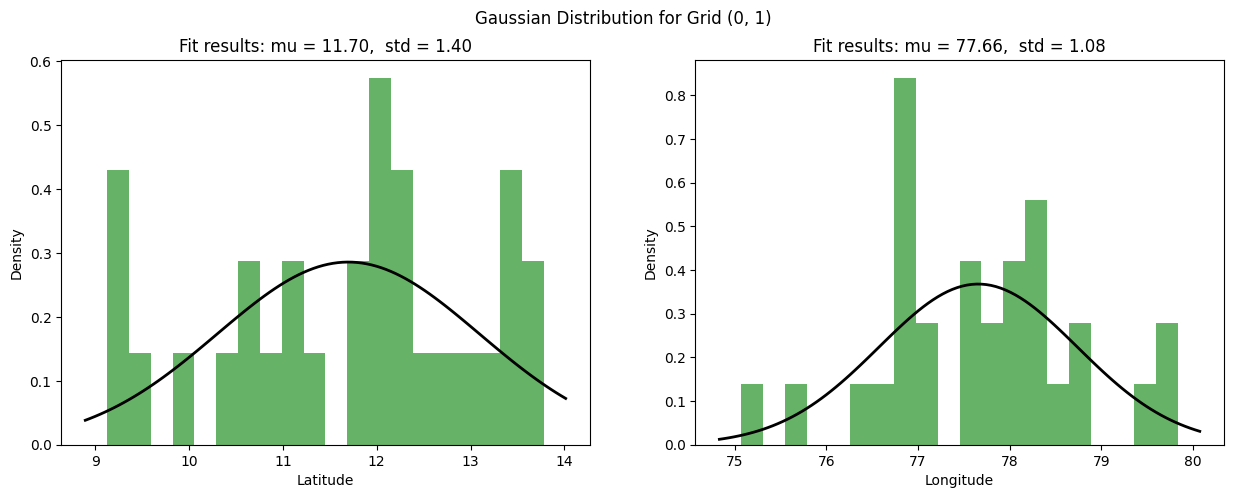

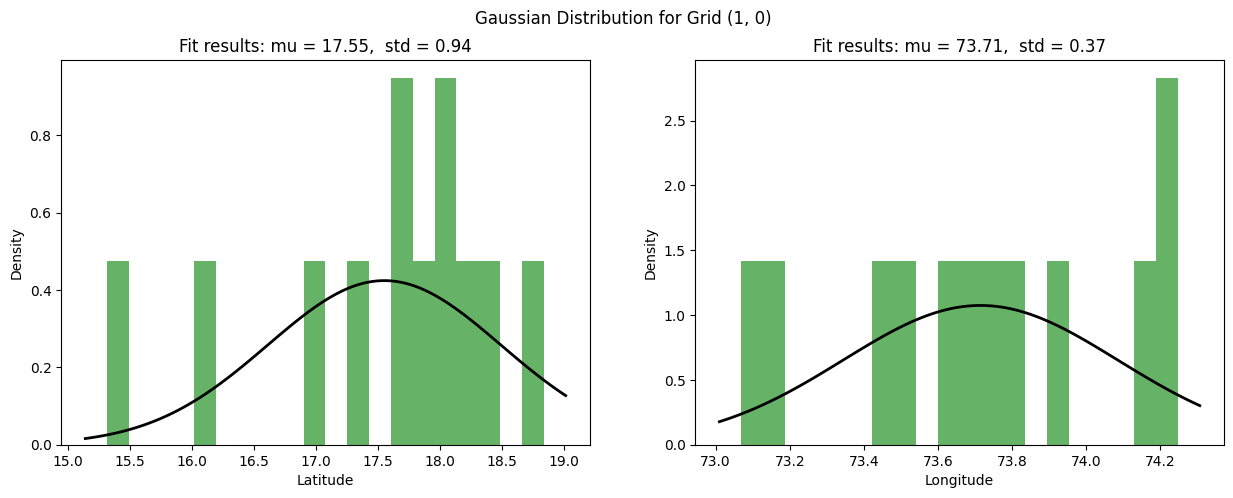

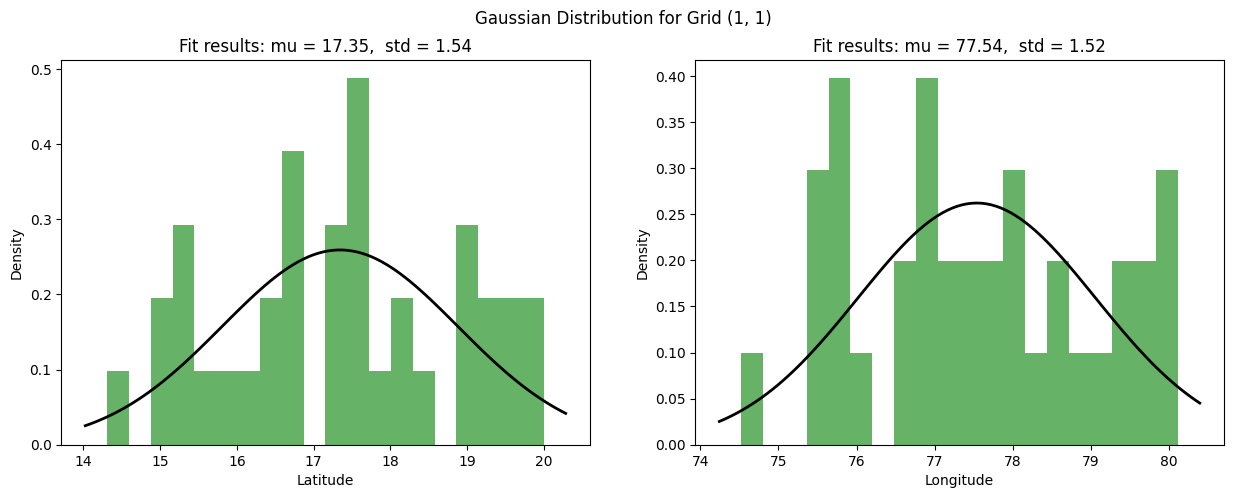

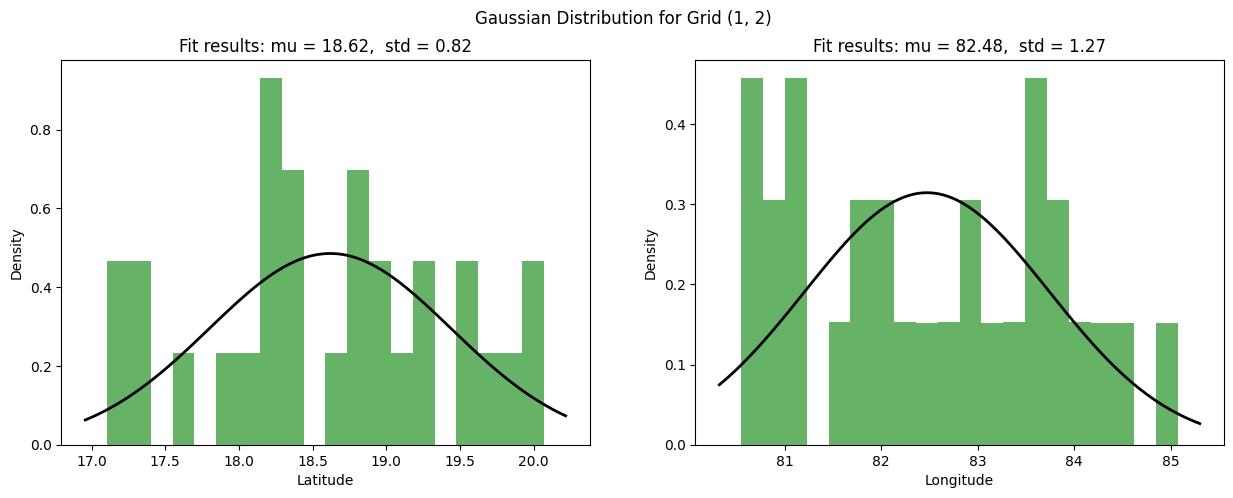

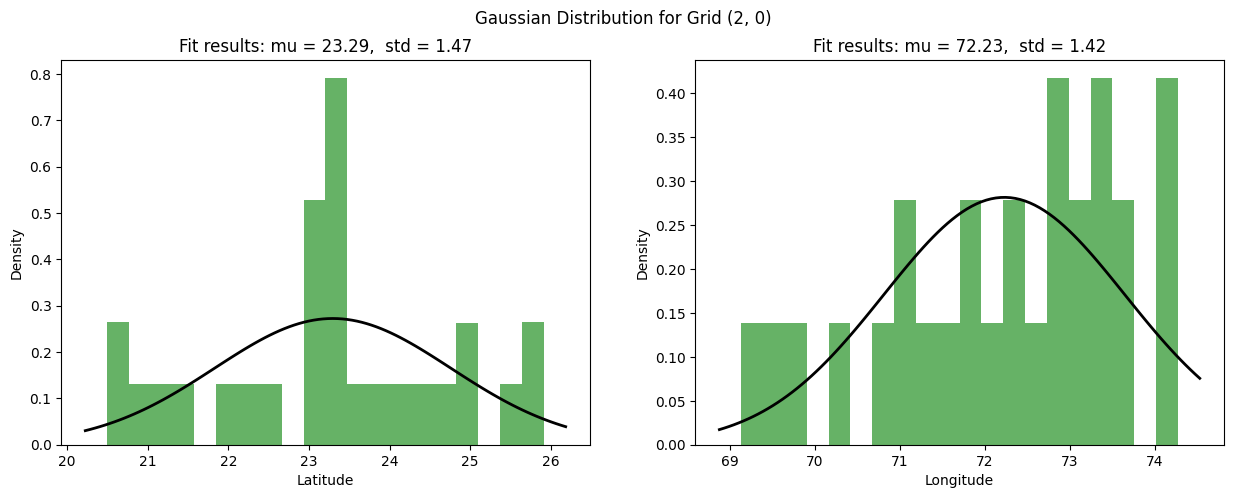

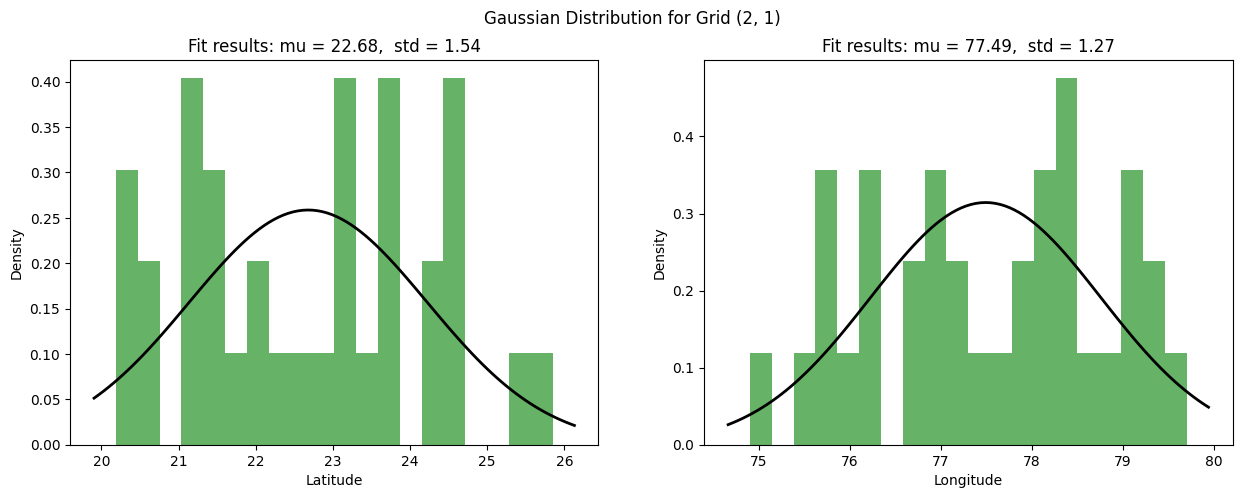

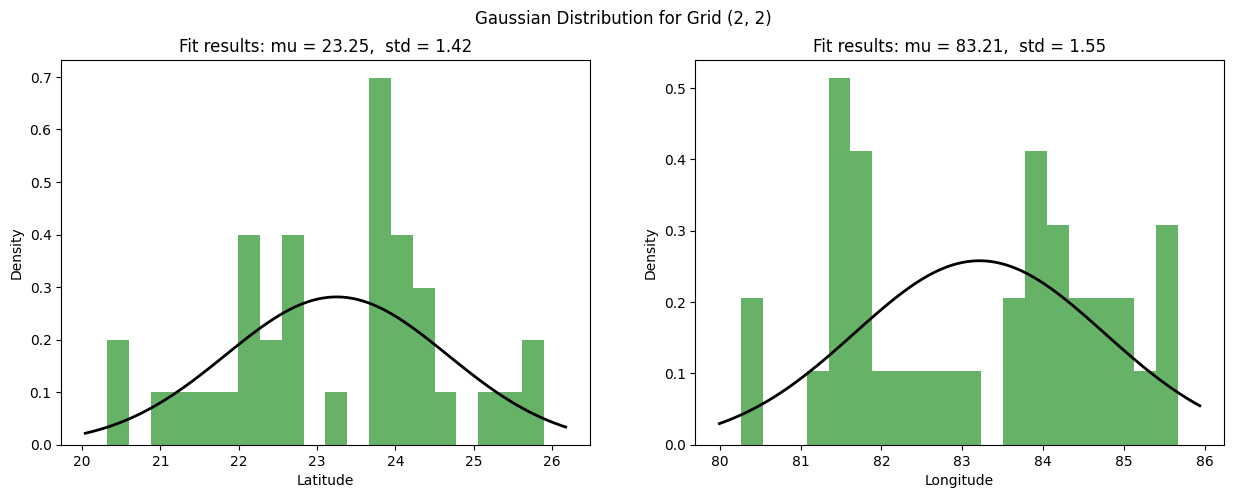

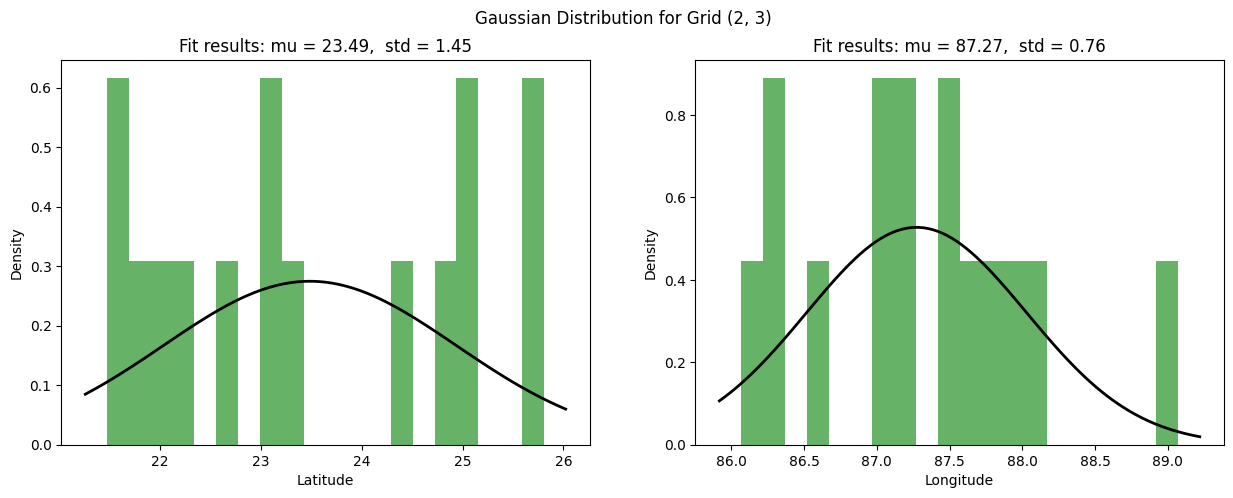

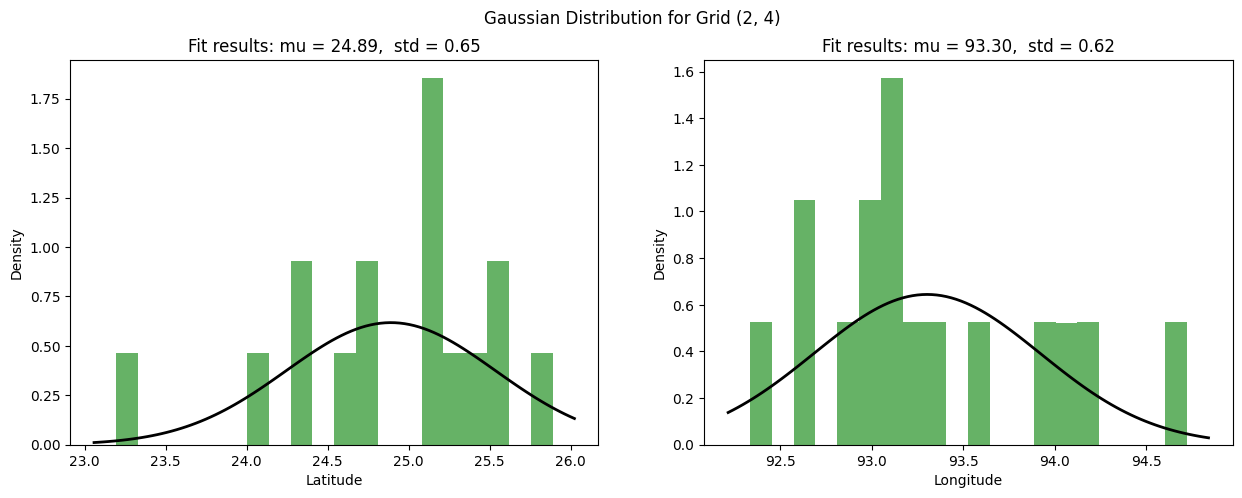

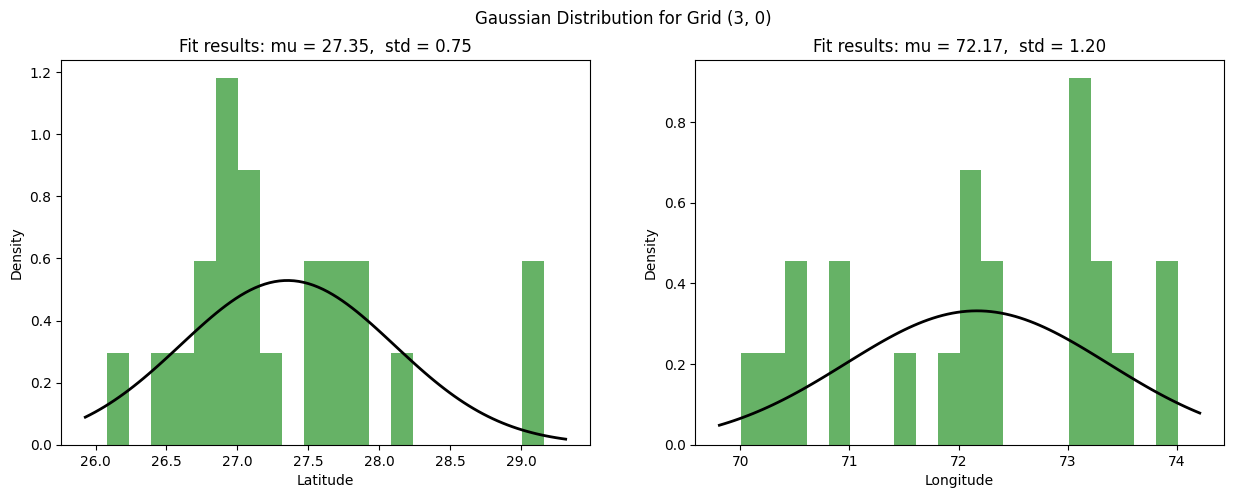

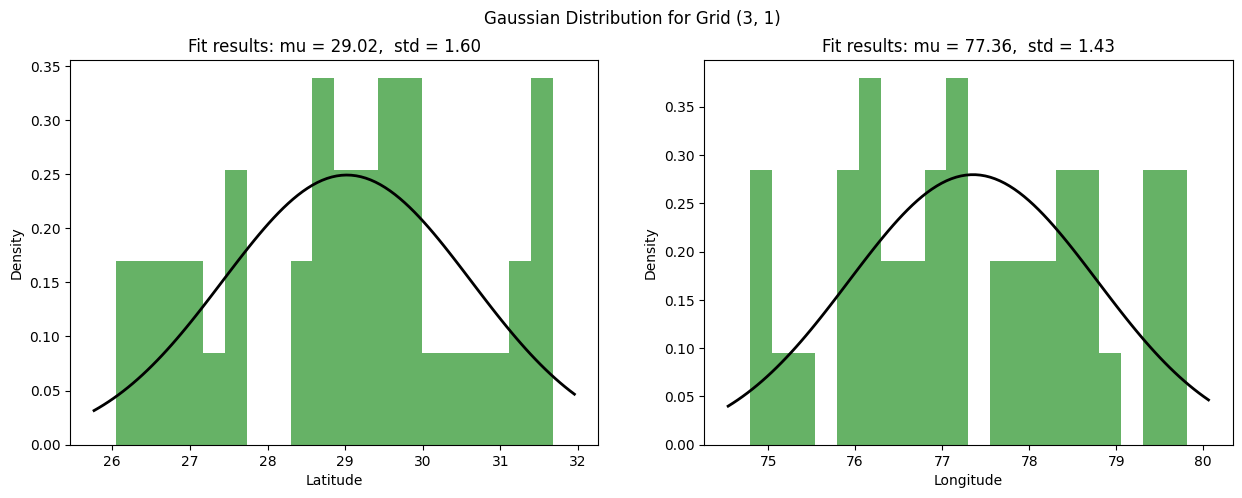

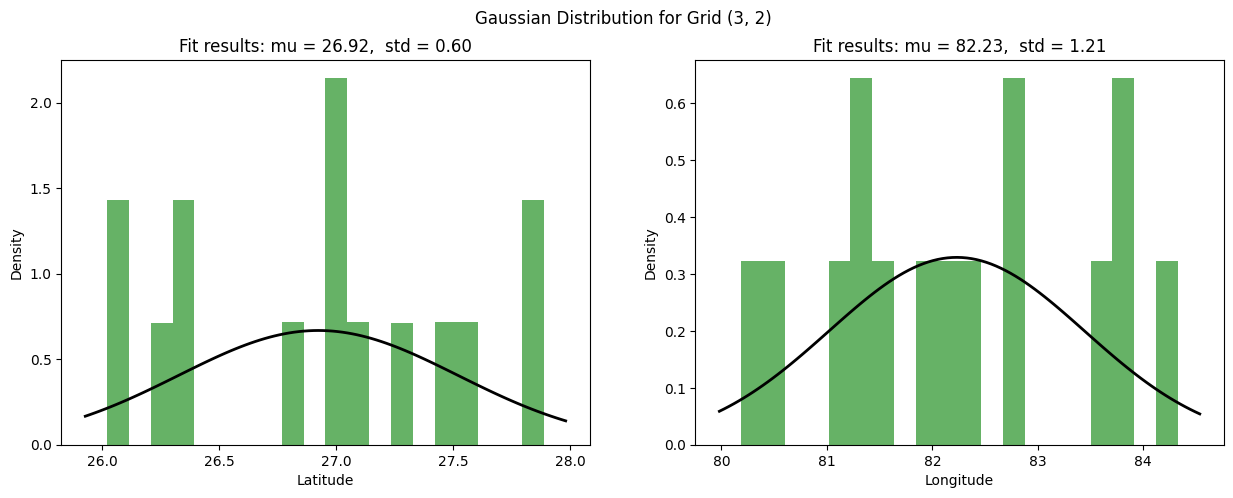

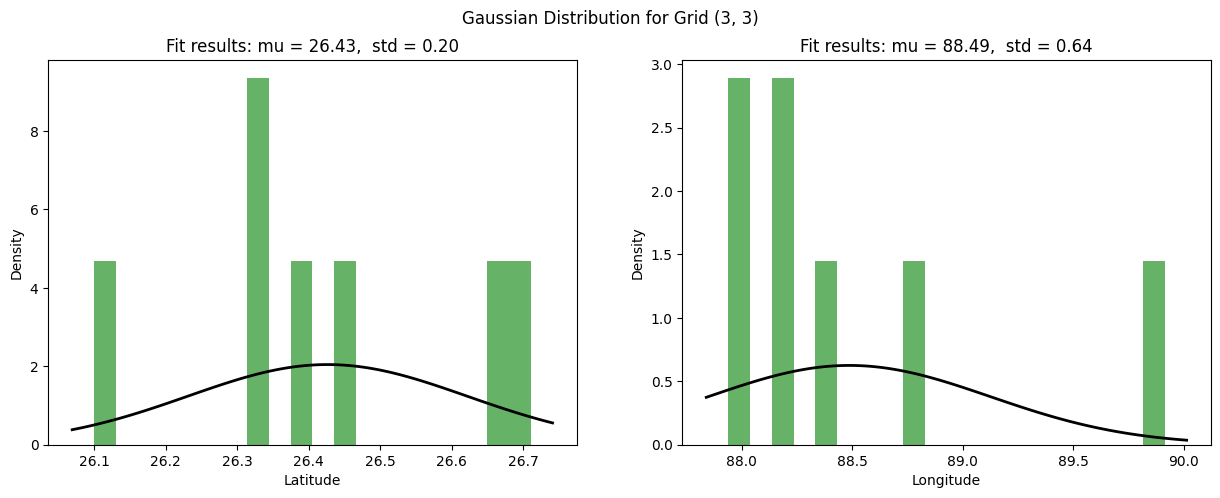

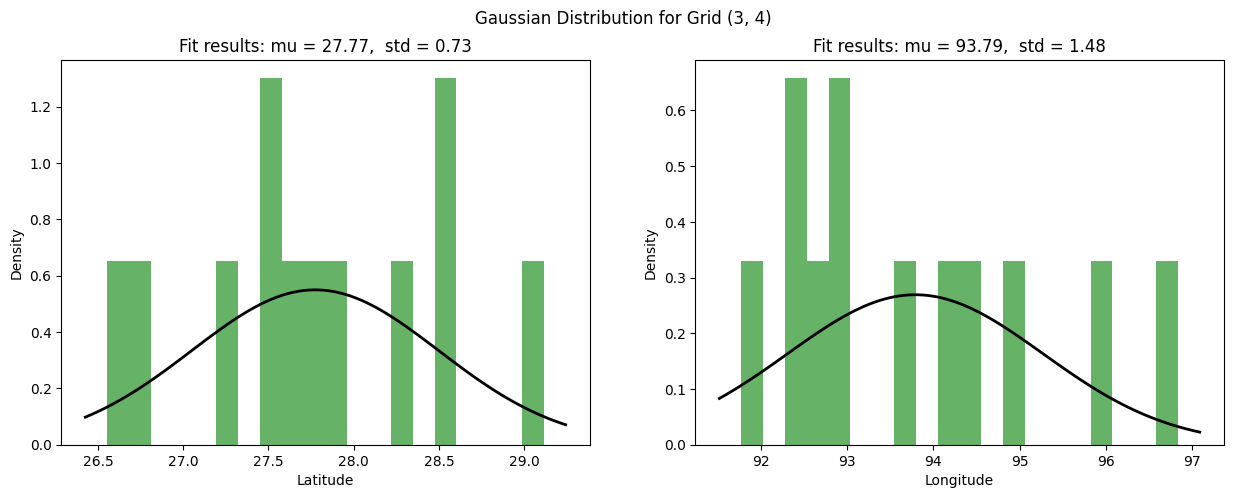

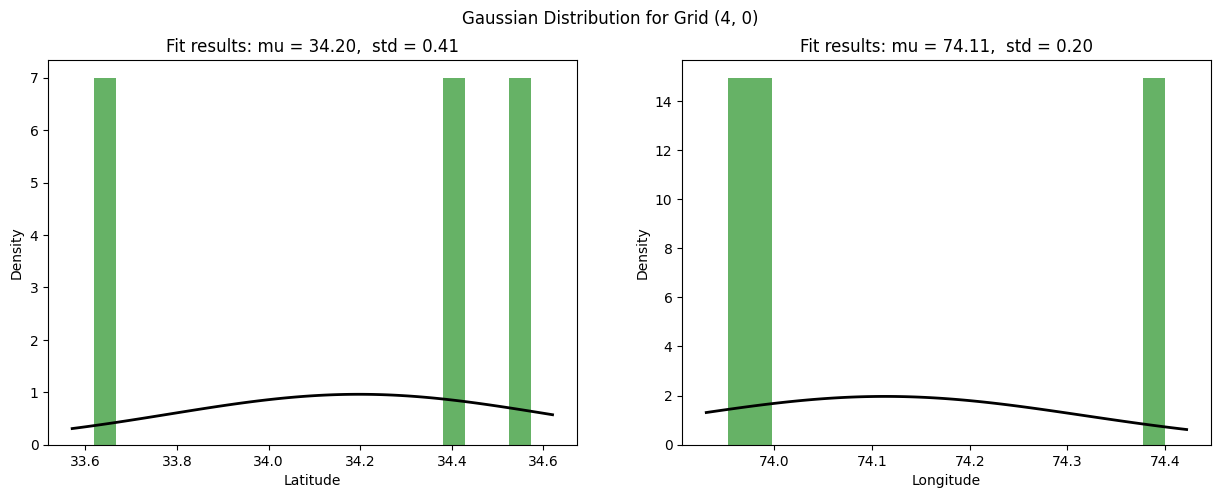

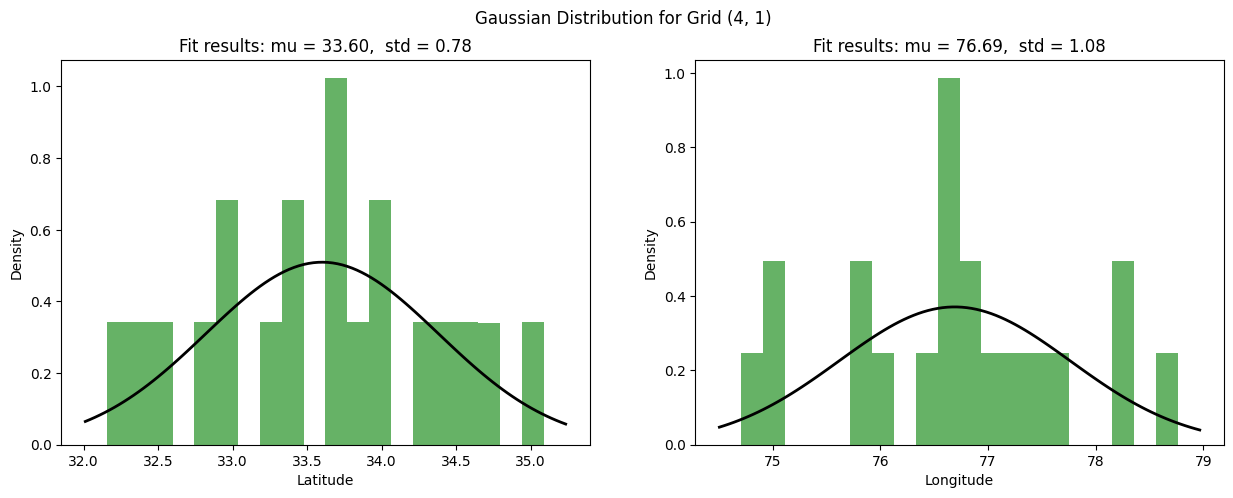

In [4]:
import scipy.stats as stats
# Plot distribution curves for each grid that covers India
for i, j, grid_points_inside, grid_points_outside in intersecting_grids:
    lat_values = [lat for lat, lon in grid_points_inside]
    lon_values = [lon for lat, lon in grid_points_inside]

    if len(lat_values) > 0 and len(lon_values) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Plot histogram and Gaussian curve for latitudes
        ax1.hist(lat_values, bins=20, density=True, alpha=0.6, color='g')

        # Fit a normal distribution to the data:
        mu, std = stats.norm.fit(lat_values)
        xmin, xmax = ax1.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax1.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        ax1.set_title(title)
        ax1.set_xlabel('Latitude')
        ax1.set_ylabel('Density')

        # Plot histogram and Gaussian curve for longitudes
        ax2.hist(lon_values, bins=20, density=True, alpha=0.6, color='g')

        # Fit a normal distribution to the data:
        mu, std = stats.norm.fit(lon_values)
        xmin, xmax = ax2.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax2.plot(x, p, 'k', linewidth=2)
        title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
        ax2.set_title(title)
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Density')

        plt.suptitle(f'Gaussian Distribution for Grid ({i}, {j})')
        plt.show()

In [5]:
import os
import csv
# Save all points to a single CSV file in the current directory
csv_filename = 'random_points_allChu.csv'



with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Latitude', 'Longitude', 'Location'])
    writer.writerows(random_points_inside)

print(f"All random points saved in {csv_filename}.")

All random points saved in random_points_all.csv.


In [6]:
print(len(random_points_inside))

358
